In [245]:
import numpy as np
import pandas as pd
import spacy
import calamancy
import string
import sklearn
import re
from wordcloud import WordCloud
from vectorizer import combined_vector
import importlib
import all_links
import brands
import my_stopwords

from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score


import pickle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline


nlp_en = spacy.load("en_core_web_sm")
nlp_tl = calamancy.load("tl_calamancy_md-0.1.0")


c:\Users\Yissus\AppData\Local\Programs\Python\Python311\Lib\site-packages\spacy\util.py:918: UserWarning: [W094] Model 'tl_calamancy_md' (0.1.0) specifies an under-constrained spaCy version requirement: >=3.5.0. This can lead to compatibility problems with older versions, or as new spaCy versions are released, because the model may say it's compatible when it's not. Consider changing the "spacy_version" in your meta.json to a version range, with a lower and upper pin. For example: >=3.7.2,<3.8.0
  warnings.warn(warn_msg)


In [246]:
df = pd.read_csv('merged-set.csv', encoding = "ISO-8859-1")
df.shape

(873, 2)

In [247]:
df.drop_duplicates(inplace=True)
df.shape

(854, 2)

In [248]:
df.isnull().sum()

label      0
message    0
dtype: int64

In [249]:
print(nlp_tl.Defaults.stop_words)


{'kami', 'nilang', 'isa', 'walang', 'paggawa', 'lahat', 'minsan', 'huwag', 'amin', 'tayo', 'palabas', 'marapat', 'muli', 'pumupunta', 'noon', 'kaysa', 'na', 'ilan', 'kanya', 'gagawin', 'pababa', 'bababa', 'nagkaroon', 'inyong', 'sabi', 'pagkakaroon', 'atin', 'iyon', 'o', 'nabanggit', 'hanggang', 'paraan', 'iba', 'ni', 'panahon', 'akin', 'kanyang', 'ka', 'katulad', 'kapag', 'siya', 'habang', 'aking', 'katiyakan', 'narito', 'may', 'ang', 'ginagawa', 'tatlo', 'nito', 'laban', 'pamamagitan', 'kumuha', 'pareho', 'mga', 'ng', 'pangalawa', 'ako', 'gusto', 'ibaba', 'ito', 'namin', 'saan', 'alin', 'niya', 'nasaan', 'kahit', 'kanila', 'mahusay', 'ibig', 'kaya', 'kailangan', 'ano', 'maging', 'kailanman', 'iyo', 'kanino', 'ilagay', 'dito', 'am', 'dapat', 'ginawa', 'nais', 'pumunta', 'una', 'karamihan', 'pagitan', 'mismo', 'mula', 'ibabaw', 'bawat', 'lamang', 'pagkatapos', 'sabihin', 'nakita', 'napaka', 'naging', 'din', 'sila', 'ilalim', 'tulad', 'dahil', 'bago', 'lima', 'nila', 'sarili', 'pataas',

In [250]:
print(nlp_en.Defaults.stop_words)


{'their', 'using', 'most', 'than', 'somewhere', 'own', 'whereafter', 'nowhere', 'eight', 'perhaps', 'see', 'although', 'three', "'s", 'fifty', 'after', 'must', 'thereupon', 'indeed', 'therefore', 'thru', 'out', '‘re', 'ever', 'becomes', 'around', '‘s', 'mine', 'being', 'very', 'top', 'themselves', 'seem', 'this', 'such', 'together', 'a', 'she', 'well', 'yours', '‘d', 'be', 'himself', 'quite', 'throughout', 'anyone', 'off', 'becoming', 'why', 'hers', 'due', 'was', 'those', 'further', 'though', 'toward', 'became', 'various', 'during', 'through', 'hundred', 'among', 'empty', 'whereas', 'ours', 'beforehand', 'front', 'make', 'wherever', '’re', 'at', 'what', 'then', 'i', 'ten', 'please', 'these', 'herself', 'put', 'whether', 'few', 'sometime', 'rather', 'been', 'thus', 'us', 'alone', 'neither', 'fifteen', 'nor', 'did', 'become', 'myself', 'whom', 'four', 'none', 'anywhere', 'less', 'full', 'unless', 'yet', 'side', 'two', 'he', 'without', 'yourself', 'from', 'just', 'how', 'either', 'via', '

In [251]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
message_bow = cv.fit_transform(df['message'])


In [252]:
df.head()


,label,message
0,spam,"Welcome ! your have P1222 for S!ot , \r\nWeb: ..."
1,spam,"My god, at least 999P rewards waiting for you\..."
2,spam,"DEAR VIP <REAL NAME>, No. 1 Online Sabong Site..."
3,spam,"<REAL NAME>! Today, you can win the iphone14PR..."
4,spam,"Welcome ! your have P1222 for S!ot , \r\nWeb: ..."


In [253]:
df.tail()

,label,message
868,ham,"Kulang pa ang load, Ka-TM? Humiram na ng extra..."
869,ham,"Sorry, hindi sapat ang iyong points para ma-re..."
870,ham,The package 8255-1673-EKXG is out for delivery...
871,ham,"Hey, GOMO Fam! We wish to inform you that ther..."
872,ham,"NDRRMC: (2:05 PM, 22Jul21) Orange Rainfall War..."


In [254]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 854 entries, 0 to 872
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    854 non-null    object
 1   message  854 non-null    object
dtypes: object(2)
memory usage: 20.0+ KB


In [255]:
df.describe()

,label,message
count,854,854
unique,2,854
top,spam,"Welcome ! your have P1222 for S!ot , \r\nWeb: ..."
freq,542,1


In [256]:
df.groupby('label').describe().T

label                                                         ham  \
message count                                                 312   
        unique                                                312   
        top      good morning sir. <REAL NAME>. this is <REAL ...   
        freq                                                    1   

label                                                        spam  
message count                                                 542  
        unique                                                542  
        top     Welcome ! your have P1222 for S!ot , \r\nWeb: ...  
        freq                                                    1

In [257]:
df['length'] = df['message'].apply(len)
df.head()

,label,message,length
0,spam,"Welcome ! your have P1222 for S!ot , \r\nWeb: ...",70
1,spam,"My god, at least 999P rewards waiting for you\...",82
2,spam,"DEAR VIP <REAL NAME>, No. 1 Online Sabong Site...",214
3,spam,"<REAL NAME>! Today, you can win the iphone14PR...",161
4,spam,"Welcome ! your have P1222 for S!ot , \r\nWeb: ...",69


In [258]:
# Count the frequency of top 5 messages.
df['message'].value_counts().rename_axis(['message']).reset_index(name='counts').head()

,message,counts
0,"Welcome ! your have P1222 for S!ot , \r\nWeb: ...",1
1,Para mabalik yung hihiramin mo.,1
2,"Day handa kana sa tayuman na ako,TX kita pag l...",1
3,Labas kna nak,1
4,Day e chat mo labas sa akin low bat mama mo,1


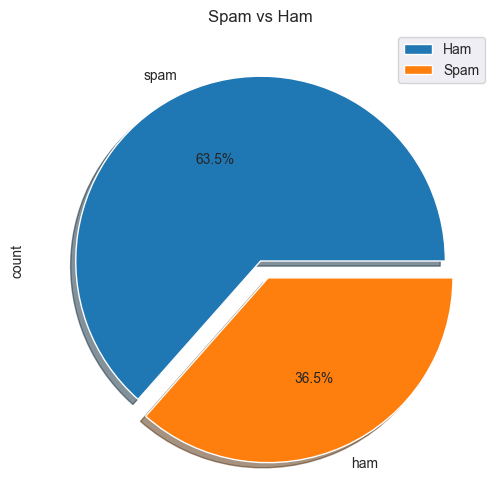

In [259]:
df["label"].value_counts().plot(kind = 'pie',explode=[0, 0.1],figsize=(6, 6),autopct='%1.1f%%',shadow=True)
plt.title("Spam vs Ham")
plt.legend(["Ham", "Spam"])
plt.show()

Text(0, 0.5, 'Frequency')

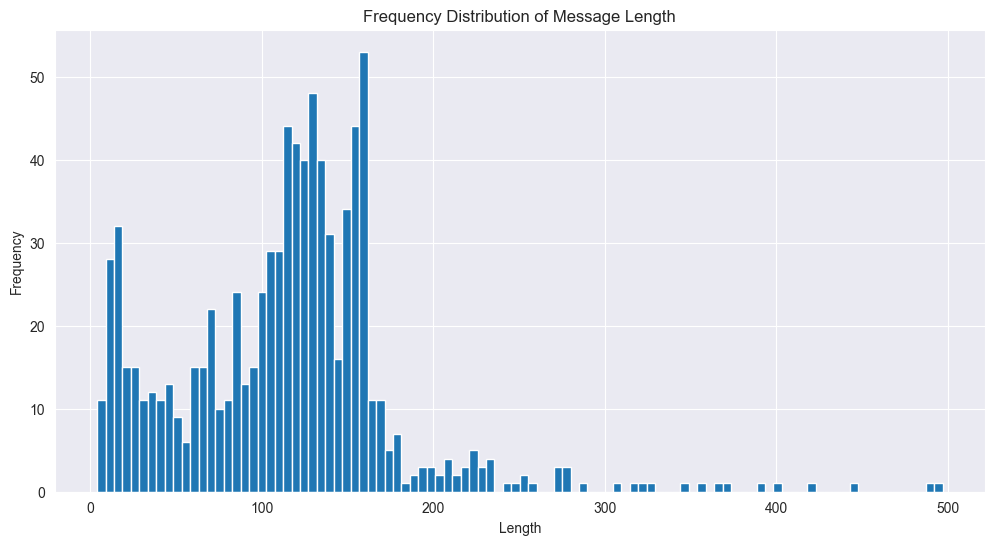

In [260]:
plt.figure(figsize=(12,6))
df['length'].plot(bins=100, kind='hist') # with 100 length bins (100 length intervals) 
plt.title("Frequency Distribution of Message Length")
plt.xlabel("Length")
plt.ylabel("Frequency")

In [261]:
df['length'].describe()

count    854.000000
mean     114.058548
std       64.494418
min        4.000000
25%       73.000000
50%      119.000000
75%      148.000000
max      497.000000
Name: length, dtype: float64

In [262]:
df[df['length'] == 497]['message'].iloc[0]

'Hi <REAL NAME>. Sorry, we are unable to activate your Virtual Pag-IBIG Account. To help you with your activation request, we have sent the reason/s why we were unable to activate your account to your email address <REAL NAME>*******@gm***.com. Once you have addressed these reasons, you may resubmit your Virtual Pag-IBIG Account activation request conveniently through a link we provided in the same email. We look forward to serving you online, anytime, anywhere via Virtual Pag-IBIG. Thank you.'

array([<Axes: title={'center': 'ham'}>, <Axes: title={'center': 'spam'}>],
      dtype=object)

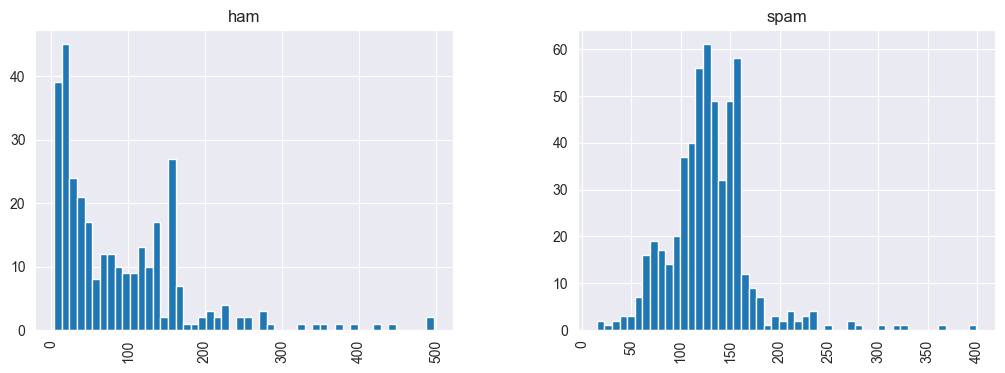

In [263]:
df.hist(column='length', by='label', bins=50,figsize=(12,4))

In [264]:
def text_preprocess(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    nopunc = nopunc.lower()
    
    # Now just remove any stopwords and non alphabets
    nostop=[word for word in nopunc.split() if word.lower() not in nlp_tl.Defaults.stop_words and word.lower() not in nlp_en.Defaults.stop_words and word.lower() not in ["real", "name"] and word.lower() not in my_stopwords.custom_stopwords and word.isalpha()]
   
    
    return nostop

In [265]:
print(my_stopwords.custom_stopwords)

['po', 'lang', 'kang', 'kayo', 'naman', 'rin', 'for', 'ba', 'mo', 'mas', 'yun', 'yung', 'yon', 'iyon', 'dyan', 'yo']


In [266]:
#vectorizing some words
def custom_vectorizer(text):
    for key, value in combined_vector.items():
        # Split the key into variations
        variations = [v.strip() for v in key.split(',') or (",")]
        
        # Create a regular expression pattern with word boundaries for each variation
        pattern = '|'.join(r'\b' + re.escape(v) + r'\b' for v in variations)
        
        # Use re.sub with the pattern for replacement
        text = re.sub(pattern, value, text, flags=re.IGNORECASE)
   
    return text

In [267]:
#dropping of links
importlib.reload(all_links)
df['message'] = df['message'].apply(lambda message: ' '.join(word for word in message.split() if all(url not in word for url in all_links.list_links)))

# Display the modified DataFrame
print(df)


    label                                            message  length
0    spam  Welcome ! your have P1222 for S!ot , Web: 11y....      70
1    spam  My god, at least 999P rewards waiting for you ...      82
2    spam  DEAR VIP <REAL NAME>, No. 1 Online Sabong Site...     214
3    spam  <REAL NAME>! Today, you can win the iphone14PR...     161
4    spam  Welcome ! your have P1222 for S!ot , Web: grea...      69
..    ...                                                ...     ...
868   ham  Kulang pa ang load, Ka-TM? Humiram na ng extra...     272
869   ham  Sorry, hindi sapat ang iyong points para ma-re...     221
870   ham  The package 8255-1673-EKXG is out for delivery...     140
871   ham  Hey, GOMO Fam! We wish to inform you that ther...     371
872   ham  NDRRMC: (2:05 PM, 22Jul21) Orange Rainfall War...     160

[854 rows x 3 columns]


In [268]:
#dropping of brands
importlib.reload(brands)
lowercase_brands = [brand.lower() for brand in brands.all_brands]

# Apply the transformation to the 'message' column
df['message'] = df['message'].apply(
    lambda message: ' '.join(word for word in message.split() if all(brand not in word.lower() for brand in lowercase_brands))
)
print(df)





    label                                            message  length
0    spam  Welcome ! your have P1222 for S!ot , Web: 11y....      70
1    spam  My god, at least 999P rewards waiting for you ...      82
2    spam  DEAR VIP <REAL NAME>, No. 1 Online Sabong Site...     214
3    spam  <REAL NAME>! Today, you can win the iphone14PR...     161
4    spam  Welcome ! your have P1222 for S!ot , Web: grea...      69
..    ...                                                ...     ...
868   ham  Kulang pa ang load, Humiram na ng extrang P20 ...     272
869   ham  Sorry, hindi sapat ang iyong points para ma-re...     221
870   ham  The package 8255-1673-EKXG is out for delivery...     140
871   ham  Hey, Fam! We wish to inform you that there wil...     371
872   ham  NDRRMC: (2:05 PM, 22Jul21) Orange Rainfall War...     160

[854 rows x 3 columns]


In [269]:
df['message'] = df['message'].apply(custom_vectorizer)
print (df)

    label                                            message  length
0    spam  Welcome ! your have P1222 for S!ot , Web: 11y....      70
1    spam  My god, at least 999P rewards waiting for you ...      82
2    spam  DEAR VIP <REAL NAME>, No. 1 Online Sabong Site...     214
3    spam  <REAL NAME>! Today, you can win the iphone14PR...     161
4    spam  Welcome ! your have P1222 for S!ot , Web: grea...      69
..    ...                                                ...     ...
868   ham  Kulang pa ang load, Humiram na ng extrang P20 ...     272
869   ham  Sorry, hindi sapat ang iyong points para ma-re...     221
870   ham  The package 8255-1673-EKXG is out for delivery...     140
871   ham  Hey, Fam! We wish to inform you that there wil...     371
872   ham  NDRRMC: (2:05 PM, 22Jul21) Orange Rainfall War...     160

[854 rows x 3 columns]


In [270]:
df['message'] = df['message'].apply(lambda message: ' '.join(text_preprocess(message)))
print(df)

    label                                            message  length
0    spam                        welcome sot web good lucksi      70
1    spam              god rewards waiting uri best baraha r      82
2    spam  dear vip online sabong site sbet register play...     214
3    spam  today win earning ton cash prizes receive sign...     161
4    spam            welcome sot web greatslife good luckyou      69
..    ...                                                ...     ...
868   ham  load humiram extrang load mababang service fee...     272
869   ham  sorry sapat points maredeem reward pang offers...     221
870   ham  package delivery today prepare cash payment re...     140
871   ham  hey fam wish inform system activity july mn ap...     371
872   ham  ndrrmc pm orange rainfall warning tarlac pampa...     160

[854 rows x 3 columns]


In [271]:
spam_messages = df[df["label"] == "spam"]["message"]
ham_messages = df[df["label"] == "ham"]["message"]
print("No of spam messages : ",len(spam_messages))
print("No of ham messages : ",len(ham_messages))

No of spam messages :  542
No of ham messages :  312


In [272]:
df.head()

,label,message,length
0,spam,welcome sot web good lucksi,70
1,spam,god rewards waiting uri best baraha r,82
2,spam,dear vip online sabong site sbet register play...,214
3,spam,today win earning ton cash prizes receive sign...,161
4,spam,welcome sot web greatslife good luckyou,69


In [273]:
spam_words = text_preprocess(spam_messages)

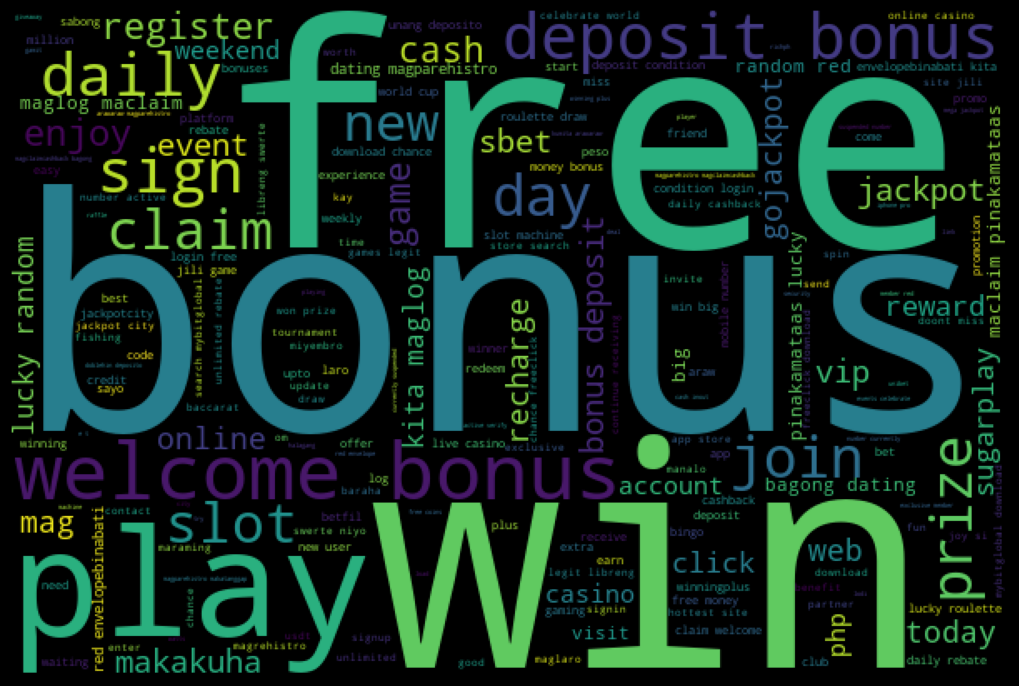

In [274]:
spam_wordcloud = WordCloud(width=600, height=400).generate(' '.join(spam_words))
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [275]:
# This may take a while...
ham_words = text_preprocess(ham_messages)

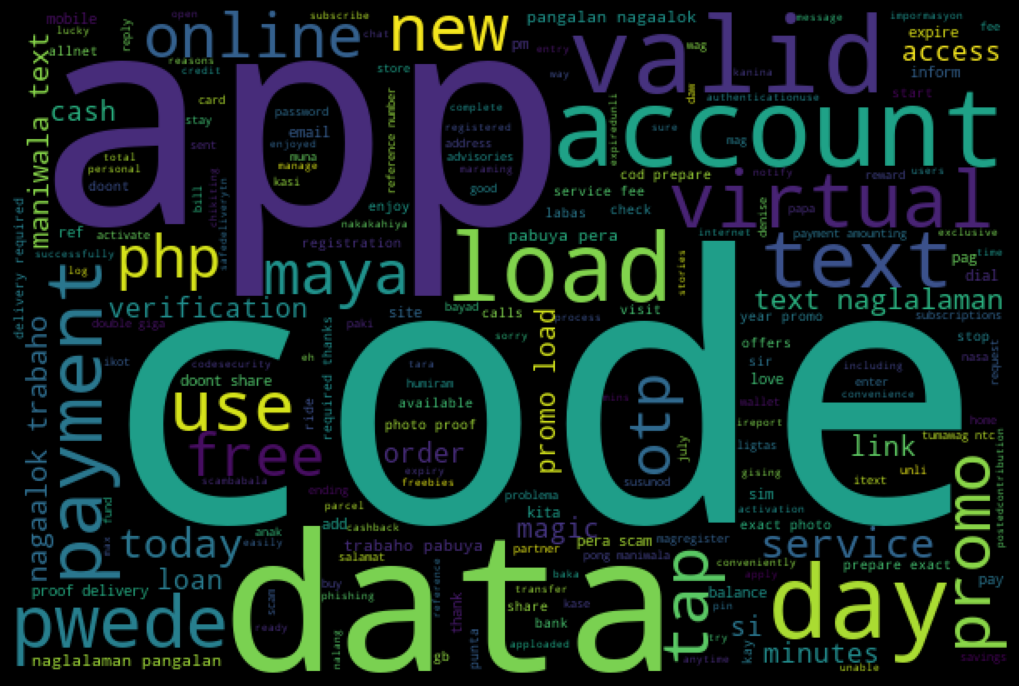

In [276]:
ham_wordcloud = WordCloud(width=600, height=400).generate(' '.join(ham_words))
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(ham_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [277]:

print (df)

    label                                            message  length
0    spam                        welcome sot web good lucksi      70
1    spam              god rewards waiting uri best baraha r      82
2    spam  dear vip online sabong site sbet register play...     214
3    spam  today win earning ton cash prizes receive sign...     161
4    spam            welcome sot web greatslife good luckyou      69
..    ...                                                ...     ...
868   ham  load humiram extrang load mababang service fee...     272
869   ham  sorry sapat points maredeem reward pang offers...     221
870   ham  package delivery today prepare cash payment re...     140
871   ham  hey fam wish inform system activity july mn ap...     371
872   ham  ndrrmc pm orange rainfall warning tarlac pampa...     160

[854 rows x 3 columns]


In [278]:
df.head()

,label,message,length
0,spam,welcome sot web good lucksi,70
1,spam,god rewards waiting uri best baraha r,82
2,spam,dear vip online sabong site sbet register play...,214
3,spam,today win earning ton cash prizes receive sign...,161
4,spam,welcome sot web greatslife good luckyou,69


In [279]:
df['message'] = df['message'].apply(lambda message: ' '.join(text_preprocess(message)))

In [280]:
# Creating the Bag of Words

# Note the here we are passing already process messages (after removing punctuations and stopwords)

vectorizer = CountVectorizer()
bow_transformer = vectorizer.fit(df['message'])

print("20 Bag of Words (BOW) Features: \n")
print(vectorizer.get_feature_names_out()[0:2277])

print("\nTotal number of vocab words : ",len(vectorizer.vocabulary_))

20 Bag of Words (BOW) Features: 

['aalis' 'abalang' 'abangan' ... 'ylast' 'yoearn' 'zoom']

Total number of vocab words :  2006


In [281]:
message4 = df['message'][3]
print(message4)

today win earning ton cash prizes receive signup bonus click


In [282]:
# fit_transform : Learn the vocabulary dictionary and return term-document matrix.
bow4 = bow_transformer.transform([message4])
print(bow4)
print(bow4.shape)

  (0, 198)	1
  (0, 245)	1
  (0, 282)	1
  (0, 431)	1
  (0, 1435)	1
  (0, 1496)	1
  (0, 1652)	1
  (0, 1811)	1
  (0, 1814)	1
  (0, 1966)	1
(1, 2006)


In [283]:
#print(bow_transformer.get_feature_names_out()[2006])

In [284]:
messages_bow = bow_transformer.transform(df['message'])

In [285]:
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse Matrix:  (854, 2006)
Amount of Non-Zero occurences:  6741


In [286]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(messages_bow)

In [287]:
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

  (0, 1966)	0.20713023246660608
  (0, 1814)	0.4572452379019836
  (0, 1811)	0.2718193100408325
  (0, 1652)	0.3674350083293264
  (0, 1496)	0.33598168238529696
  (0, 1435)	0.29107656759896827
  (0, 431)	0.4309774296614023
  (0, 282)	0.24871234264894687
  (0, 245)	0.2600077198541122
  (0, 198)	0.16222511768027742


In [288]:
print(bow_transformer.get_feature_names_out()[0])
print(bow_transformer.get_feature_names_out()[1982])

aalis
wln


In [289]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['aalis']])

7.0579542883768145


In [290]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(854, 2006)


In [291]:
from sklearn.feature_extraction.text import TfidfVectorizer

# English stopwords from TfidfVectorizer
english_stopwords = set(TfidfVectorizer(stop_words="english").get_stop_words())

# Your custom stopwords
custom_stopwords = set(my_stopwords.custom_stopwords)

# Tagalog stopwords
tagalog_stopwords = set(nlp_tl.Defaults.stop_words)

# Merging all stopwords
all_stopwords = list(english_stopwords.union(custom_stopwords).union(tagalog_stopwords))

vec = TfidfVectorizer(encoding="latin-1", strip_accents="unicode", stop_words=all_stopwords)
features = vec.fit_transform(df["message"])

print(features.shape)  # Shape of the TF-IDF matrix
print(len(vec.vocabulary_))  # Total number of unique terms in the vocabulary


(854, 2002)
2002


In [292]:

from sklearn.model_selection import train_test_split
msg_train, msg_test, label_train, label_test = \
train_test_split(messages_tfidf, df['label'], test_size=0.2)


In [293]:
print("train dataset features size : ",msg_train.shape)
print("train dataset label size", label_train.shape)

print("\n")

print("test dataset features size", msg_test.shape)
print("test dataset lable size", label_test.shape)

train dataset features size :  (683, 2006)
train dataset label size (683,)


test dataset features size (171, 2006)
test dataset lable size (171,)


In [294]:
message_bow.shape

(854, 3341)

In [295]:
parameters = {'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]}  # Example values for alpha

clf = MultinomialNB()
spam_detect_model = clf.fit(msg_train, label_train)
grid_search = GridSearchCV(clf, parameters, cv=5, scoring='accuracy')
grid_search.fit(msg_train, label_train)
best_classifier = grid_search.best_estimator_
predict_train = best_classifier.predict(msg_train)


In [296]:
from sklearn import metrics
print("Classification Report \n",metrics.classification_report(label_train, predict_train))
print("\n")
print("Confusion Matrix \n",metrics.confusion_matrix(label_train, predict_train))
print("\n")
print("Accuracy of Train dataset : {0:0.3f}".format(metrics.accuracy_score(label_train, predict_train)))

Classification Report 
               precision    recall  f1-score   support

         ham       0.98      0.98      0.98       248
        spam       0.99      0.99      0.99       435

    accuracy                           0.98       683
   macro avg       0.98      0.98      0.98       683
weighted avg       0.98      0.98      0.98       683



Confusion Matrix 
 [[242   6]
 [  6 429]]


Accuracy of Train dataset : 0.982


In [297]:
label_predictions = best_classifier.predict(msg_test)
print(label_predictions)

['spam' 'spam' 'spam' 'ham' 'ham' 'ham' 'ham' 'spam' 'spam' 'spam' 'spam'
 'spam' 'spam' 'spam' 'spam' 'ham' 'ham' 'ham' 'ham' 'spam' 'spam' 'spam'
 'spam' 'spam' 'spam' 'ham' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam'
 'spam' 'ham' 'spam' 'ham' 'spam' 'spam' 'spam' 'ham' 'spam' 'ham' 'spam'
 'ham' 'spam' 'ham' 'ham' 'spam' 'ham' 'ham' 'ham' 'spam' 'ham' 'ham'
 'ham' 'ham' 'ham' 'ham' 'spam' 'ham' 'ham' 'spam' 'spam' 'spam' 'ham'
 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'ham'
 'ham' 'spam' 'ham' 'ham' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'ham'
 'ham' 'spam' 'spam' 'spam' 'ham' 'ham' 'spam' 'spam' 'spam' 'spam' 'ham'
 'spam' 'spam' 'spam' 'spam' 'ham' 'spam' 'spam' 'spam' 'spam' 'spam'
 'spam' 'spam' 'ham' 'spam' 'spam' 'spam' 'ham' 'spam' 'ham' 'spam' 'ham'
 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'ham' 'ham'
 'spam' 'spam' 'spam' 'ham' 'ham' 'ham' 'ham' 'spam' 'ham' 'spam' 'ham'
 'spam' 'spam' 'spam' 'ham' 'ham' 'spam' 'spam' 'spam' 'spam' 's

In [298]:

test_accuracy = accuracy_score(label_test, label_predictions)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.9298245614035088


In [299]:

from sklearn import metrics
print(metrics.classification_report(label_test, label_predictions))
print(metrics.confusion_matrix(label_test, label_predictions))

              precision    recall  f1-score   support

         ham       0.89      0.92      0.91        64
        spam       0.95      0.93      0.94       107

    accuracy                           0.93       171
   macro avg       0.92      0.93      0.93       171
weighted avg       0.93      0.93      0.93       171

[[ 59   5]
 [  7 100]]


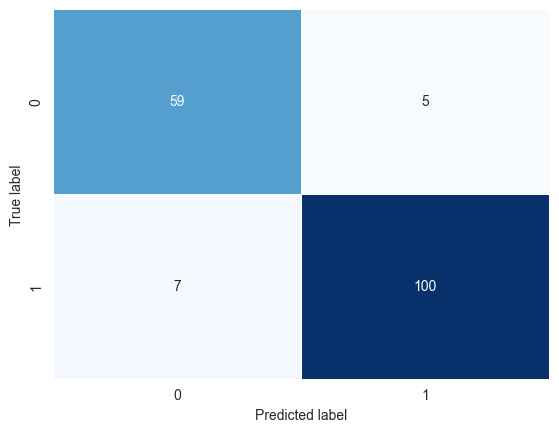

In [300]:
def plot_confusion_matrix(y_true, y_pred):
   mtx = metrics.confusion_matrix(y_true, y_pred)
   sns.heatmap(mtx, annot=True, fmt='d', linewidths=.5, 
               cmap="Blues", cbar=False)
   plt.ylabel('True label')
   plt.xlabel('Predicted label')
plot_confusion_matrix(label_test, label_predictions)

Accuracy of the model : 0.930


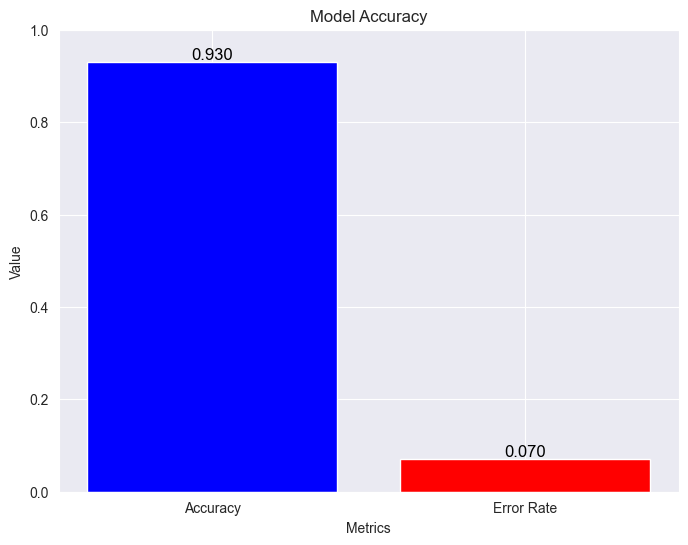

In [301]:

# Calculate accuracy
test_accuracy = metrics.accuracy_score(label_test, label_predictions)
print("Accuracy of the model : {0:0.3f}".format(test_accuracy))

# Visualize accuracy using a bar chart
accuracies = [test_accuracy, 1 - test_accuracy]  # Accuracy and error rate
labels = ['Accuracy', 'Error Rate']

plt.figure(figsize=(8, 6))
bars = plt.bar(labels, accuracies, color=['blue', 'red'])
plt.title('Model Accuracy')
plt.xlabel('Metrics')
plt.ylabel('Value')
plt.ylim(0, 1)  # Set y-axis limit between 0 and 1

# Display exact values on the bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, 
             bar.get_height(), 
             f'{acc:.3f}', 
             ha='center', 
             va='bottom', 
             color='black',
             fontsize=12)

plt.show()


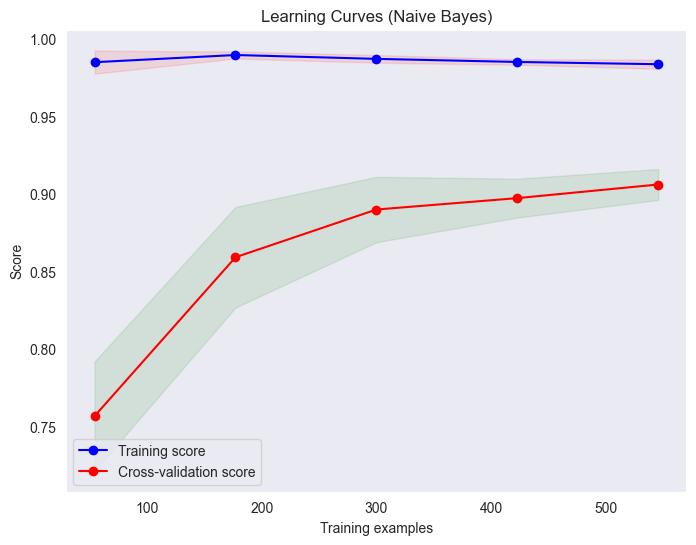

In [302]:
from sklearn.model_selection import learning_curve
import numpy as np

# Define a function to plot learning curves
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(8, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes, scoring='accuracy', n_jobs=-1)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="blue", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="red", label="Cross-validation score")

    plt.legend(loc="best")
    return plt


title = "Learning Curves (Naive Bayes)"
cv = 5  # Cross-validation folds

plot_learning_curve(best_classifier, title, msg_train, label_train, cv=cv)
plt.show()


In [303]:
import pandas as pd

def learning_curve_table(estimator, X, y, cv=None, train_sizes=np.linspace(.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes, scoring='accuracy', n_jobs=-1)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    
    data = {'Training Size': train_sizes, 'Training Score': train_scores_mean, 'Validation Score': test_scores_mean}
    df = pd.DataFrame(data)
    return df

# Assuming 'best_classifier', 'msg_train', and 'label_train' are defined
cv = 5  # Cross-validation folds
train_sizes = np.linspace(.1, 1.0, 5)  # Vary this if needed

learning_curve_df = learning_curve_table(best_classifier, msg_train, label_train, cv=cv, train_sizes=train_sizes)
print(learning_curve_df)


   Training Size  Training Score  Validation Score
0             54        0.985185          0.756848
1            177        0.989831          0.859328
2            300        0.987333          0.890125
3            423        0.985343          0.897477
4            546        0.983883          0.906269


In [304]:
import joblib

# Save the model
joblib.dump(spam_detect_model, 'spam_model.joblib')

# Load the model
loaded_model = joblib.load('spam_model.joblib')
joblib.dump(vectorizer, 'vectorizer.joblib')


['vectorizer.joblib']

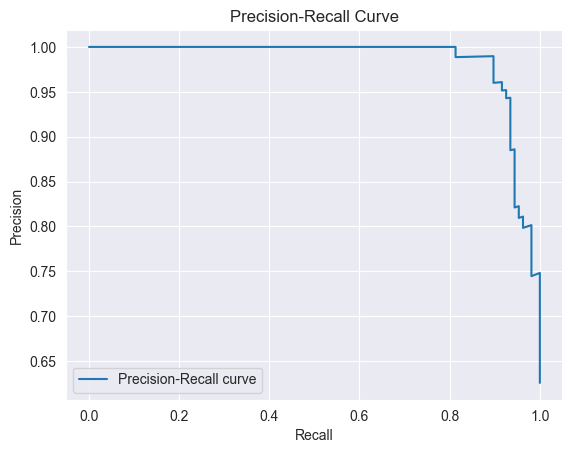

AUC: 0.9843808802845863
Optimal Threshold: 0.6479933191798792


In [305]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Assuming model is your trained classifier
y_scores = spam_detect_model.predict_proba(msg_test)[:, 1]

# Convert string labels to binary values
y_test_binary = label_binarize(label_test, classes=['ham', 'spam'])

# Use OneVsRestClassifier to handle multiclass/multilabel indicators
model = OneVsRestClassifier(spam_detect_model)

precision, recall, thresholds = precision_recall_curve(y_test_binary, y_scores)

# Plot Precision-Recall Curve
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

# Calculate AUC (Area Under the Curve) for Precision-Recall Curve
auc_score = auc(recall, precision)
print(f'AUC: {auc_score}')

# Find the threshold for a specific point on the curve (e.g., where precision and recall are balanced)
balance_point_index = np.argmax(precision + recall)
optimal_threshold = thresholds[balance_point_index]
print(f'Optimal Threshold: {optimal_threshold}')
